In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, nn, value_and_grad
import pylab as pl
from IPython.display import clear_output
import optax

In [7]:
class RNG:
    def __init__(self, seed):
        self.key = jax.random.PRNGKey(seed)

    def sample(self, shape):
        key, _ = jax.random.split(self.key)
        self.key = key
        return jax.random.normal(self.key, shape)

    
    def __call__(self, shape):
        return self.sample(shape)

rng = RNG(42)

In [2]:
import pandas as pd
import numpy as np
train_data = pd.read_csv("data/train_data.csv")
X_train = train_data["full_text_cleaned"]

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(strip_accents="unicode", min_df=100, max_df=0.3, binary=True).fit(X_train)

X_train = vectorizer.transform(X_train)

In [4]:
@jit
def fill_diagonal(x, value=0):
    diag_elements = jnp.diag_indices(x.shape[0])
    return x.at[diag_elements].set(value)


@jit
def get_topic_from_logits(topic_logits):
    return nn.softmax(topic_logits, axis=1)


@jit
def topic_independence_loss(topic_logits):
    topics = get_topic_from_logits(topic_logits)
    topic_correlation = jnp.einsum('ik,jk->ij', topics, topics)
    return fill_diagonal(topic_correlation, value=0).sum()


@jit
def topic_document_loss(a, documents, topic_logits):
    topics = get_topic_from_logits(topic_logits)
    return optax.l2_loss(a@topics, documents).sum()


@jit
def total_loss(params, documents, l=1):
    a = params["a"]
    topic_logits = params["topic_logits"]
    return topic_document_loss(a, documents, topic_logits) + l*topic_independence_loss(topic_logits)


grad_topic_document_loss = jit(value_and_grad(topic_document_loss))
grad_topic_independence_loss = jit(value_and_grad(topic_independence_loss))
grad_total_loss = jit(value_and_grad(total_loss))

In [10]:
n_documents, vocab_size = X_train.shape
n_topics = 4
batch_size = 2**16
outer_lr = 1
inner_lr = 1

X_train = X_train[np.random.permutation(X_train.shape[0])]

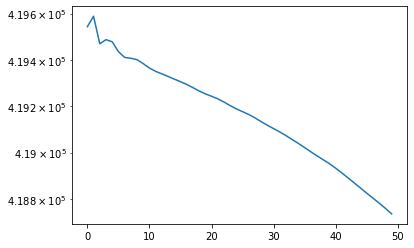

In [18]:
optimizer = optax.adamw(learning_rate=1
params = {
    "topic_logits": rng((n_topics, vocab_size)),
    "a": rng((batch_size, n_topics)),
}
opt_state = optimizer.init(params)

documents = jnp.array(X_train[:batch_size].todense())

losses = []
for epoch in range(50):
    value, grads = grad_total_loss(params, documents, l=1e5)

    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    losses.append(value)

    clear_output(True)
    pl.semilogy(losses)
    pl.show()


In [21]:
topic_words = params["topic_logits"].argsort(axis=1)[:, -5:]

for words in topic_words:
    print([vectorizer.get_feature_names()[i] for i in words[::-1]])

['new', '0000', 'year', 'say', 'video']
['make', 'get', 'us', 'want', 'way']
['photo', 'look', 'week', 'day', 'see']
['00', 'one', 'day', 'like', 'thing']
